# 1 Author

**Student Name**:  Liu Ruitong
**Student ID**:  210985746

*Hello! Thank you for reading. You can choose to visit my github repo for a better reading experience!: [https://github.com/Alixyvtte/Smile-Face-and-Glasses-Detection]*

# 2 Problem formulation
The machine learning problem that I want to solve is to build a pipeline that can perform two tasks:
 
（1）Smile Detection （2）3D Head Pose Estimation

For Smile Detection, this is a binary classification problem. We need to design a model that can analyze facial expressions in an image and predict whether the person is smiling or not, by training on the genki4k image dataset. The training data we need to use are images and labels for both smile content (1=smile, 0=non-smile).

For 3D Head Pose Estimation, this is a regression problem. The task of 3D head pose estimation involves predicting the orientation of a person’s head in three-dimensional space based on a 2D image. The goal is to estimate the pitch, yaw, and roll angles that represent the head pose. The training data we need to use are images and three head pose labels.

**Then...What's interesting? &#x1F62E;**
* We need to design a Multi-Modal Approach to integrate both binary classification and regression problems into a single pipeline.

* The dataset exhibits variations in brightness, angles, and other characteristics of images. How should we preprocess the dataset to prevent the introduction of excessive noise during the training process?

* Smile Detection and 3D Head Pose Estimation emphasize different facial features. How do we select an appropriate network model to accommodate these distinct aspects?

# 3 Machine Learning pipeline
The proposed Machine Learning pipeline consists of three main parts: 

(1) Data Preprocessing (or transformation) 
(2) Feature Extraction 
(3) Outputs Integration
The following will introduce each stage in detail.

**Input:** Original images and .txt label files

*Stage 1: Data transformation*

First, in order to obtain higher quality training images with clearer features, I choose to use the pre-trained CascadeClassifier from cv2 to locate and crop the faces in the images and resize the photo for consistency, to eliminate the interference that may exist in the surrounding environment, and delete overly complex images. 

*Output(next input):*   Cropped images, all with the shape of (64x64)

*Stage 2: Feature Extraction*

This step uses a fine-tuned LetNet5 architecture to train my model, and designs different processing layers according to the different needs of binary classification and regression tasks. The specific model architecture can be found in the experimental results in the Result section.

*Output:*   The trained model and the evaluation matrix on the test set

*Stage 3: Outputs Integration*

 In order to achieve the goal of obtaining an image and directly outputting the smile detection result and 3D Head Pose result, I design the *detect_smile* function to integrate the outputs, and call the cv2.putText and cv2.rectangle methods to visualize the prediction results.
 
*Output:*   For Smile Detection, the model output is a binary classification probability result; For 3D Head Pose Estimation, the model output is three values, representing pitch, yaw, and roll angles.

**Output:**  The integrated result image.

# 4 Transformation stage
The transformations used in the proposed method mainly include the data preprocessing and feature extraction stages, and the processes are as follows:

—————————————————— Data Preprocessing ———————————————

***input:***  Origin image with different size

cascade_model.detectMultiScale --> Detected parts position (x, y, width, height)

A region of interest (ROI) is extracted --> Image [y: y + h, x: x + w]

***output:*** A list of cropped images with size (64x64)

*Why I have chosen this method...:* &#x1F615;

Cascade models use a series of classifiers to quickly eliminate non-face regions in an image, making them suitable for our speed requirement. I choose to use this model to crop out accurate face images first, to provide a higher quality training set for the subsequent smile detection task.

————————————————— Feature Extraction —————————————————

***input:***  Cropped images with size (64x64)

BGR image (OpenCV's cvtColor)  --> Grayscale image

Grayscale image --> NumPy array --> Make it between 0 to 1

***output:*** A list of NumPy array

*Why I have chosen this method...:* &#x1F615;

Converting the image to grayscale simplifies the representation by reducing the number of channels from three (RGB) to one, which makes it computationally more efficient for smile detection and feature extraction. NumPy arrays provide a standardized format for image data, making them suitable for inputting into the next proposed networks.

# 5 Modelling
The ML models I used are based on LeNet, the architecture setup is as follows:

*Input Layer:*

The model expects input images with a shape of (imgRows, imgCols, numChannels)

*Convolutional Layers:*

Two sets of Convolutional => Activation => Pooling layers:
First set: 20 filters, kernel size 5x5, "same" padding, and ReLU activation.
MaxPooling layer with a 2x2 pool size and 2x2 strides.
Second set: 50 filters, kernel size 5x5, "same" padding, and ReLU activation.
MaxPooling layer with a 2x2 pool size and 2x2 strides.

*Fully Connected (FC) Layers:*

First FC layer with 500 units and ReLU activation.
Depending on the type of task:
If task is binary classification, it adds a second FC layer with outputDim units and a softmax activation (typical for classification tasks).
If task is regression, it adds a second FC layer with outputDim units and a linear activation.

*Why I have chosen this model...:* &#x1F603;
LeNet, a classic convolutional neural network, is recognized for its effectiveness in image classification tasks. Its simplicity makes it advantageous for smile detection, focusing on identifying facial expression patterns. Originally designed for recognizing handwritten digits, LeNet has proven successful in various image classification scenarios. Despite the distinct nature of smile detection and 3D head pose estimation , LeNet's fundamental principles of feature extraction and hierarchical learning provide a solid starting point. Moreover, considering computational resources and dataset complexity, the lightweight LeNet is also a practical choice.

# 6 Methodology
**Dataset Setup:**

Data split ratio: train:validate = 4:1; train:test = 4:1. The data was shuffled before partitioning.

**Training & Testing Setup:**

I opted to train separate models for two distinct tasks on the genki4k dataset and integrate them into a unified pipeline. 

During training, binary crossentropy is used as the loss function for the smile detection task, while mean_squared_error was chosen as the loss function for 3D head pose estimation. Both tasks employed the Adam optimizer and accuracy as the metric. The models achieved their best performance (the final models used for testing) with batch_size = 32 and epochs = 20, leveraging a Tesla T4 GPU.

For testing, configured the batch_size as 64 and employed the classification_report to showcase the model's performance on the test set. This report offers a comprehensive analysis, presenting metrics such as precision, recall, and F1-score for each class.

In [76]:
import os
import cv2
import numpy as np
from enum import Enum
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 7 Dataset

The **GENKI4** dataset is an image database that contains facial expressions spanning a wide range of illumination conditions, personal identity, and ethnicity. It consists of 4000 face images, each labeled with smile content (1=smile, 0=non-smile) and head pose (yaw, pitch, and roll parameters, in radians).

The following represents the data preprocessing process, along with the visualization of some raw data samples and data after preprocessing.

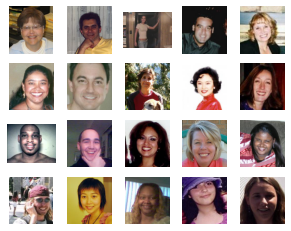

In [19]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the folder path for images
folder_path = r'/content/drive/MyDrive/genki4k/files'

# Get all image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg'))]

# Select the first twenty images
selected_images = image_files[:20]

# Set up the subplot
plt.figure(figsize=(5, 4))
for i, image_file in enumerate(selected_images, 1):
    plt.subplot(4, 5, i)
    
    # Read and display the image
    image_path = os.path.join(folder_path, image_file)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    
    # Turn off the axis
    plt.axis('off')

# Show the images
plt.show()


In [77]:
class Cascade_model(Enum):
    class Face(Enum):
        Name = "face"
        Model = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        Scale_factor = 1.3
        Min_Neighbors = 5

In [78]:
source_folder_path = '/content/drive/MyDrive/genki4k/files'
smiles_folder_path = "/content/drive/MyDrive/genki4k/smiles"
width = 64
height = 64

In [80]:
def Read_labels():
    f = open("/content/drive/MyDrive/genki4k/labels.txt", "r")
    label_binary = np.empty(0)
    label_regression = []

    row = f.readline()
    while row != "":
        col = row.split()
        label_binary = np.append(label_binary, col[0])
        regression_values = [float(col[i]) for i in range(1, 4)]  # Assuming the next three values are for regression
        label_regression.append(regression_values)
        row = f.readline()

    f.close()
    return label_binary, np.array(label_regression)

In [82]:
# get index of a sample
def Get_sample_index(filename):
   file_part = filename.split("-")[0]
   number_part = file_part[4:]
   return int(number_part) - 1

In [83]:
def get_size_ratio(min_width, min_height, ratio = (4,3)):
    if ratio[0] > ratio[1]:
        if min_width > min_height:
            min_height = min_width * ratio[1] / ratio[0]
        else:
            min_width = min_height * ratio[0] / ratio[1]
    else:
        if min_width > min_height:
            min_height = min_width * ratio[1] / ratio[0]
        else:
            min_width = min_height * ratio[0] / ratio[1]
    return round(min_width), round(min_height)

In [84]:
def crop_photo_parts(image, cascade_model, should_resize = False, height = 128, width = 128):

    # detects parts in the input image
    parts = cascade_model.Model.value.detectMultiScale(image,
    cascade_model.Scale_factor.value,
    cascade_model.Min_Neighbors.value)

    cropped_parts = []
    locations = []

    # save detected parts
    if len(parts) > 0:
        for (x, y, w, h) in parts:

            # get the best width and height for being ready to resize
            if should_resize:
                w, h = get_size_ratio(w,h, (width, height))
            part = image[y:y + h, x:x + w]

            # resize the photo for consistency
            if should_resize:
                part = cv2.resize(part, (width, height), interpolation=cv2.INTER_LINEAR)

            # store parts and locations
            cropped_parts.append(part)
            locations.append((x, y, w, h))

    return cropped_parts , locations

In [86]:
def part_croper(input_folder_path, target_folder_path, cascade_model, should_resize=False, height=128, width=128):
    images = os.listdir(input_folder_path)

    # Remove old files
    files_to_remove = os.listdir(target_folder_path)
    if len(files_to_remove) > 0:
        for file in files_to_remove:
            os.remove(os.path.join(target_folder_path, file))

    # Count the number of images without detected faces
    images_without_faces = 0

    if len(images) > 0:
        for image in images:
            if not ".jpg" in image.lower():
                continue

            # Read the image
            img = cv2.imread(os.path.join(input_folder_path, image))

            # Detect parts
            parts, locations = crop_photo_parts(img, cascade_model, should_resize, height, width)

            # Save detected parts
            if len(parts) > 0:
                for i in range(len(parts)):
                    file_name = os.path.join(target_folder_path, f'{image[:-4]}-{cascade_model.Name.value}{i+1}.jpg')
                    if os.path.exists(file_name):
                        os.remove(file_name)
                    cv2.imwrite(file_name, parts[i])
                    # print(file_name)
            else:
                # print(image, f"No {cascade_model.Name.value} detected!")
                images_without_faces += 1

            # If the target folder doesn't exist, create it
            if not os.path.exists(target_folder_path):
                os.makedirs(target_folder_path)

    print(f"Total {images_without_faces} images without detected faces.")


In [87]:
# detect faces
part_croper(source_folder_path, smiles_folder_path, Cascade_model.Face.value, True, height, width)

Total 476 images without detected faces.


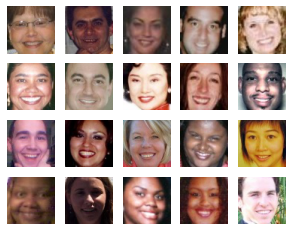

In [20]:
folder_path = r"D:\PyCharm\PycharmProjects\CBU5201\MiniProject\genki4k\smiles"
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg'))]
selected_images = image_files[:20]
plt.figure(figsize=(5, 4))
for i, image_file in enumerate(selected_images, 1):
    plt.subplot(4, 5, i)
    
    image_path = os.path.join(folder_path, image_file)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [88]:
# get list of samples
samples = os.listdir(smiles_folder_path)
labels_files, lable_regression = Read_labels()

In [89]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

data = []
labels = []
posture = [] # for pose labels

# collect data from samples
for image in samples:
    img = cv2.imread(os.path.join(smiles_folder_path,image))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = img_to_array(gray)
    data.append(gray)
    index = Get_sample_index(image)
    labels.append(labels_files[index])
    posture.append(lable_regression[index])

posture=np.array(posture)

In [90]:
# convert the labels from integers to vectors
le = LabelEncoder().fit(labels)
labels = to_categorical(le.transform(labels), 2)
# convert to numpy array and make it between 0 to 1
data = np.array(data, dtype = "float") / 255.0

# 8 Results

The following is the experimental section and results analysis.

# The final accuracy on the test set reached 90%. &#128522;

In [91]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense, BatchNormalization, Dropout
from keras import backend as K

The model structure

In [92]:
def LeNet(numChannels, imgRows, imgCols, outputDim, activation="relu", weightsPath=None, type=None):

  # initialize the model
  model = Sequential()
  inputShape = (imgRows, imgCols, numChannels)

  # if we are using "channels first", update the input shape
  if K.image_data_format() == "channels_first":
    inputShape = (numChannels, imgRows, imgCols)

  # define the first set of CONV => ACTIVATION => POOL layers
  model.add(Conv2D(20, 5, padding="same", input_shape=inputShape))
  model.add(Activation(activation))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

      # define the second set of CONV => ACTIVATION => POOL layers
  model.add(Conv2D(50, 5, padding="same"))
  model.add(Activation(activation))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  # define the first FC => ACTIVATION layers
  model.add(Flatten())
  model.add(Dense(500))
  model.add(Activation(activation))

  if type==0 :
    # define the second FC layer
    model.add(Dense(outputDim))

    # lastly, define the soft-max classifier
    model.add(Activation("softmax"))
  else:
    model.add(Dense(outputDim, activation="linear"))
  # if a weights path is supplied (inicating that the model was
  # pre-trained), then load the weights
  if weightsPath is not None:
    model.load_weights(weightsPath)

  # return the constructed network architecture
  return model

The partitioning of the dataset and the configuration of certain model hyperparameters.

In [104]:
# get model ready
# partition the data into training and testing splits using 80% of the data
# for training and remaining 20% for testing
(trainX_s, testX_s, trainY_s, testY_s) = train_test_split(data, labels, test_size = 0.2, stratify = labels, random_state = 42)
(trainX_p, testX_p, trainY_p, testY_p) = train_test_split(data, posture, test_size = 0.2, random_state = 42)
# initialize the model
print("[INFO] compiling model...")
model_smile = LeNet(numChannels = 1, imgRows = height, imgCols = width, outputDim = 2, type=0)
model_smile.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

print("[INFO] compiling model for regression...")
model_pose = LeNet(numChannels = 1, imgRows = height, imgCols = width, outputDim=3, type=1)
model_pose.compile(loss="mean_squared_error", optimizer = "adam", metrics = ["accuracy"])

[INFO] compiling model...
[INFO] compiling model for regression...


**Model Details**

In [105]:
# print the summary of the model
model_smile.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 64, 64, 20)        520       
                                                                 
 activation_37 (Activation)  (None, 64, 64, 20)        0         
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 32, 32, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 50)        25050     
                                                                 
 activation_38 (Activation)  (None, 32, 32, 50)        0         
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 16, 16, 50)        0         
 ng2D)                                               

In [106]:
# print the summary of the model
model_pose.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 64, 64, 20)        520       
                                                                 
 activation_41 (Activation)  (None, 64, 64, 20)        0         
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 32, 32, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 50)        25050     
                                                                 
 activation_42 (Activation)  (None, 32, 32, 50)        0         
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 16, 16, 50)        0         
 ng2D)                                               

**Model Training Process**

In [107]:
# train the network
print("[INFO] training network for pose recognition...")
out_pose = model_pose.fit(trainX_p, trainY_p, validation_data = (testX_p, testY_p), batch_size = 32, epochs = 20, verbose=0)
print("[INFO] training network for smiling recognition...")
out_smile = model_smile.fit(trainX_s, trainY_s, validation_data = (testX_s, testY_s), batch_size = 32, epochs = 30, verbose = 1)

[INFO] training network for pose recognition...
[INFO] training network for smiling recognition...
Epoch 1/30
89/89 [==============================] - 3s 13ms/step - loss: 0.6856 - accuracy: 0.5637 - val_loss: 0.6601 - val_accuracy: 0.5938
Epoch 2/30
89/89 [==============================] - 1s 10ms/step - loss: 0.5794 - accuracy: 0.6945 - val_loss: 0.4810 - val_accuracy: 0.7518
Epoch 3/30
89/89 [==============================] - 1s 10ms/step - loss: 0.3756 - accuracy: 0.8381 - val_loss: 0.3594 - val_accuracy: 0.8322
Epoch 4/30
89/89 [==============================] - 1s 8ms/step - loss: 0.2934 - accuracy: 0.8808 - val_loss: 0.2948 - val_accuracy: 0.8787
Epoch 5/30
89/89 [==============================] - 1s 8ms/step - loss: 0.2434 - accuracy: 0.9093 - val_loss: 0.2827 - val_accuracy: 0.8914
Epoch 6/30
89/89 [==============================] - 1s 8ms/step - loss: 0.2378 - accuracy: 0.9086 - val_loss: 0.2603 - val_accuracy: 0.8900
Epoch 7/30
89/89 [==============================] - 1s 8ms

**Model Testing Process**

In [108]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model_smile.predict(testX_s, batch_size = 64)
print(classification_report(testY_s.argmax(axis = 1), predictions.argmax(axis = 1), target_names = le.classes_))
# save the model to disk
model_smile.save("Test.h5")
model_pose.save("Label.h5")

[INFO] evaluating network...
12/12 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       318
           1       0.93      0.89      0.91       391

    accuracy                           0.90       709
   macro avg       0.90      0.91      0.90       709
weighted avg       0.91      0.90      0.90       709


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Design a function to receive a new photo, determine whether there is a smile, and output the 3D pose.**

In [112]:
def detect_smile(frame, model_smile, model_pose):
    # detect faces
    faces, face_locations = crop_photo_parts(frame, Cascade_model.Face.value)
    for i in range(len(faces)):
        # get list of smiles
        smile_list, loacions = crop_photo_parts(faces[i], Cascade_model.Face.value, True, height, width)

        # get a clone of previous frame and count smiles
        clone_frame = frame
        j = 0

        if len(smile_list) > 0:

            # detect each sample of smile_list
            for smile in smile_list:
                gray = cv2.cvtColor(smile, cv2.COLOR_BGR2GRAY)
                sample = img_to_array(gray)
                sample = np.array(sample, dtype = "float") / 255.0
                data = []
                data.append(sample)
                data = np.array(data)

                # predict using model and find the best match
                predictions_smile = model_smile.predict(data)
                predictions_pose = model_pose.predict(data)

                label = "Smiling" if predictions_smile[0][1] > predictions_smile[0][0] else "Not Smiling"

                # asume the last frame if it isn't first sample
                if j != 0:
                    frame = clone_frame

                # put related result to the frame
                (x, y, w, h) = face_locations[i]
                cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0,255,0), 2)

                j = j + 1
                # print(str(predictions_pose))
    return frame, predictions_pose

# Let's do some testing!!... &#128515;

1/1 [==============================] - 0s 26ms/step


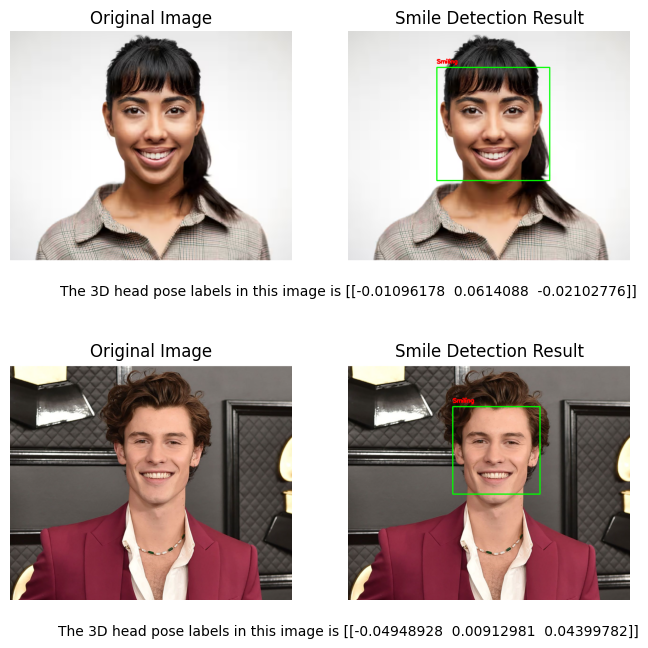

In [136]:
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

image_path_1 = '/content/drive/MyDrive/genki4k/3333.png'
image_path_2 = '/content/drive/MyDrive/genki4k/99.png'

model_smile_path = '/content/Test.h5'
model_pose_path = "/content/Label.h5"

# Load the pre-trained LeNet model
model_smile = tf.keras.models.load_model(model_smile_path)
model_pose = tf.keras.models.load_model(model_pose_path)

# Load the image
image_1 = cv2.imread(image_path_1)
image_2 = cv2.imread(image_path_2)

# Call detect_smile to perform smile detection
result_image_1, predictions_pose_1 = detect_smile(image_1, model_smile, model_pose)
result_image_2, predictions_pose_2 = detect_smile(image_2, model_smile, model_pose)

# Display the original and result images using matplotlib
plt.figure(figsize=(8, 8))

# Display original image 1
plt.subplot(2, 2, 1)
image_1 = Image.open(image_path_1)
plt.imshow(image_1)
plt.title("Original Image")
plt.axis("off")

# Display result image 1
plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(result_image_1, cv2.COLOR_BGR2RGB))
plt.title("Smile Detection Result")
plt.axis("off")
plt.text(0.0, -0.15, "The 3D head pose labels in this image is " + str(predictions_pose_1), ha='center', transform=plt.gca().transAxes)

# Display original image 2
plt.subplot(2, 2, 3)
image_2 = Image.open(image_path_2)
plt.imshow(image_2)
plt.title("Original Image")
plt.axis("off")

# Display result image 2
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(result_image_2, cv2.COLOR_BGR2RGB))
plt.title("Smile Detection Result")
plt.axis("off")
plt.text(0.0, -0.15, "The 3D head pose labels in this image is " + str(predictions_pose_2), ha='center', transform=plt.gca().transAxes)


plt.show()


**Above are two smiling pictures. You can see that the top-left corner label of the green box is "Smiling," and the 3D pose is displayed below each image.**

1/1 [==============================] - 0s 31ms/step


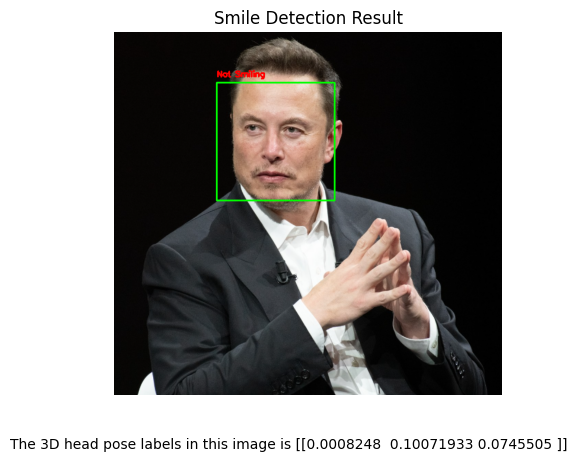

In [145]:
image_path_3 = '/content/drive/MyDrive/genki4k/musk.png'
image_3 = cv2.imread(image_path_3)

result_image_3, predictions_pose_3 = detect_smile(image_3, model_smile, model_pose)
# Display the original and result images using matplotlib
plt.figure(figsize=(5, 5))

plt.imshow(cv2.cvtColor(result_image_3, cv2.COLOR_BGR2RGB))
plt.title("Smile Detection Result")
plt.axis("off")
plt.text(0.45, -0.15, "The 3D head pose labels in this image is " + str(predictions_pose_3), ha='center', transform=plt.gca().transAxes)

plt.show()

**Above is a picture without a smile. You can see that the top-left corner label of the green box is "Not Smiling," and the 3D pose is displayed below the image.**

# 9 Conclusions
This project proposes a machine learning pipeline for detecting facial smiles and head 3D poses. The backbone network is based on LeNet, a lightweight architecture widely used in image detection tasks. The model architecture has been fine-tuned for specific binary classification and regression tasks. In the data preprocessing stage, the advantages of pre-trained models are leveraged for image cropping. After 30 epochs of training, the model achieves an overall accuracy of **90%** on the test set.

For further improvements, data augmentation techniques can be employed to increase the number of samples. In the implementation of the 3D head pose detection task, the fusion of multi-modal information can also be explored.

**Thanks for your reading !! &#128512;**